## Spaceship Titanic - basic solution 🚀
[]
This notebook is an exercise in exploratory data analysis and machine learning. It uses the [Spaceship Titanic](https://www.kaggle.com/c/spaceship-titanic) data set, which contains information about the passengers's fate on the futuristic spaceship Titanic.

#### Introduction
First, we will import the necessary libraries, load the data, and survey basic information about the data.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

train_set_eda = train_set.copy()

#### 1. Check the dataset details, missing values, datatypes and other information.
It will allow us to further choose the examination methods determine exploration strategy. We also have to check the datatypes of the features, missing values, and other information. More details about data and what it means can be found in the [dataset documentation](https://www.kaggle.com/c/spaceship-titanic/data). Reading the supplied documentation is a good way to get familiar with the problem and decide which analysis methods to use.



<AxesSubplot:xlabel='Transported', ylabel='count'>

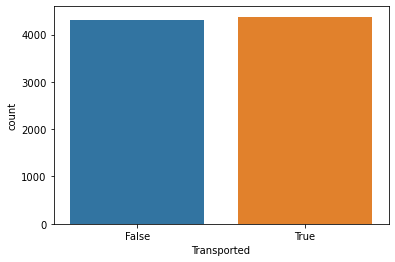

In [2]:
# check the 'Transported' column data distribution
sns.countplot(x='Transported', data=train_set_eda)

The target classes are balanced, so it makes our analysis easier - the two classes are equally represented in the data and we can use the same methods to analyze them, without over- or undersampling.

In [3]:
train_set_eda.dtypes ### check the data type of each column

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We can see that the features are of type `object` and `int64` -  the first ones are categorical types, the latter is a numerical type. The target is of boolean type - it is important to remember about submitting the correct type of target when uploading the submission.

In [4]:
train_set_eda.isnull().sum() ### check the missing value of each column

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Every column that is a meaningful feature has some missing values. Let us check if by dropping the columns with missing values we lose any meaningful information.

In [5]:
train_set_eda.isnull().sum()/train_set_eda.shape[0] ### check the fraction of missing value of each column

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

The missing values are less than 3% of each column, so dropping any column would mean losing large amount of data.

In [6]:
train_set_eda.describe() ### check the statistical summary of each column (from the numerical columns)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


From the summary, we can see that that the spending columns have outliers that are pretty far away from the mean. We will analyze these outliers in the next section.

In [7]:
train_set_eda.describe(include=['O']) ### check the statistical summary of each column (from the categorical columns)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


Some of the categorical features have too many categories (PassengerID, Cabin, Name), while others may be easily represented as a single binaruy feature (CryoSleep, VIP). We will analyze these features and decide which ones to use in our upcoming analysis.

#### 2. Check the data distribution, correlation and mutual information of the features.

First, lets get the names of numerical and categorical features.

In [8]:
### get the names of numerical and categorical columns
numerical_cols, categorical_cols = train_set_eda.dtypes[train_set.dtypes != 'object'].index, train_set_eda.dtypes[train_set.dtypes == 'object'].index

##### 2.1. Home planet

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

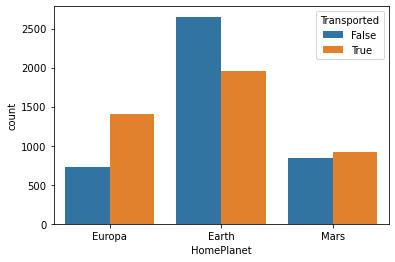

In [9]:
sns.countplot(data=train_set_eda,x='HomePlanet', hue='Transported') ### check the distribution of home planet and transported

Most of the passengers are from Earth, with majority of them not transported. The next planet is Europa (which is a moon lol), where transported passengers are more common. Mars is the least common planet, balanced when it comes to the target distribution. 

##### 2.2. CryoSleep

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

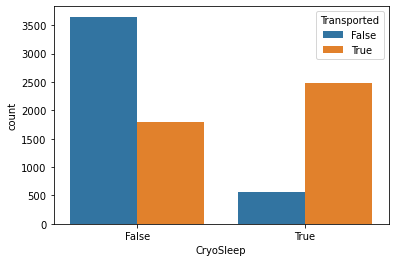

In [10]:
sns.countplot(data=train_set_eda, x='CryoSleep', hue='Transported') ### check the distribution of survived and transported

The cryosleep feature is a binary feature that indicates whether the passenger was the in cryosleep. Majority of the passengers are not in cryosleep, and are less likely to be transported, while the minority are in cryosleep and are more likely to be transported.

##### 2.3. Cabin

Cabin feature is a categorical feature that indicates the passenger's cabin. 3/4 of this feature consists of unique values, but reading documentation suggests us that this feature might be beneficial to split.

In [11]:
### test the cabin split hypothesis
train_set_eda[['Deck', 'Num', 'Side']] = train_set_eda['Cabin'].str.split('/', expand=True)
train_set_eda.drop('Cabin', axis=1, inplace=True)
train_set_eda.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Name,Deck,Num,Side
count,8693,8492,8476,8511,8490,8493,8494,8494,8494
unique,8693,3,2,3,2,8473,8,1817,2
top,0001_01,Earth,False,TRAPPIST-1e,False,Gollux Reedall,F,82,S
freq,1,4602,5439,5915,8291,2,2794,28,4288


As visible above the most *uniqueness* in this feature comes from the Cabin number. The two remaining features might be useful for our analysis, so let's plot them.

**Deck**

<AxesSubplot:xlabel='Deck', ylabel='count'>

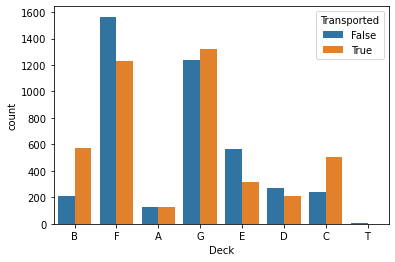

In [12]:
sns.countplot(data=train_set_eda, x='Deck', hue='Transported') ### check the distribution of deck and transported

This chart shows that passengers from some decks are more likely to be transported. Decks are also not balanced when it comes to how often they occured in the data.

**Side**

<AxesSubplot:xlabel='Side', ylabel='count'>

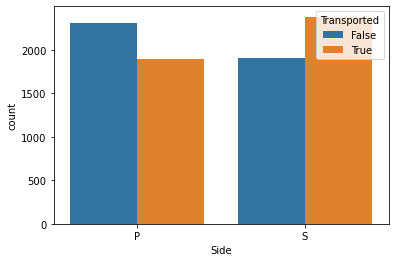

In [13]:
sns.countplot(data=train_set_eda, x='Side', hue='Transported') ### check the distribution of deck and transported

##### 2.4. Destination

<AxesSubplot:xlabel='Destination', ylabel='count'>

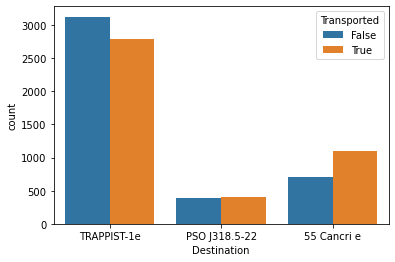

In [14]:
sns.countplot(data=train_set_eda, x='Destination', hue='Transported') ### check the distribution of survived and transported

Most people travel to the same destination - TRAPPIST-1. There is almost no correlation between the destination and the target so we will not use this feature in our analysis.

##### 2.5. Age

<AxesSubplot:xlabel='Transported', ylabel='Age'>

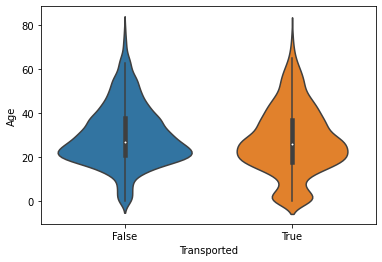

In [15]:
### check age distribution with division by transported column
sns.violinplot(x='Transported', y='Age', data=train_set_eda)

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

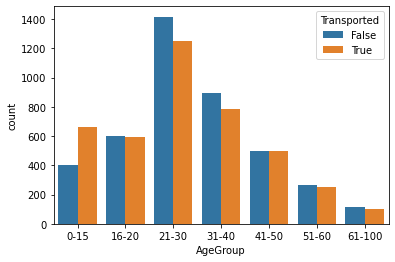

In [16]:
### group people into bins and check the distribution of age with transported column
bins = [0, 15, 20, 30, 40, 50, 60, 100]
group_names = ['0-15', '16-20', '21-30', '31-40', '41-50', '51-60', '61-100']
train_set_eda['AgeGroup'] = pd.cut(train_set_eda['Age'], bins, labels=group_names)
sns.countplot(hue='Transported', x='AgeGroup', data=train_set_eda)

Grouping people into age groups is a good way to see some interesting trends - for example the youngest passengers are more likely to be transported.

##### 2.6. VIP

<AxesSubplot:xlabel='VIP', ylabel='count'>

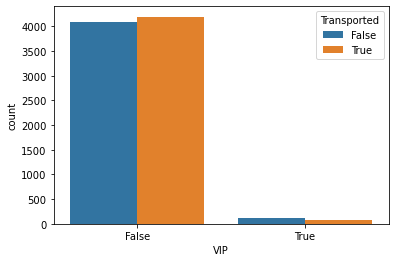

In [17]:
sns.countplot(data=train_set_eda,x='VIP', hue='Transported')

VIP feature alone is not a very useful feature, it could possibly be useful to create some additional features from it.

##### 2.7. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - ammenities

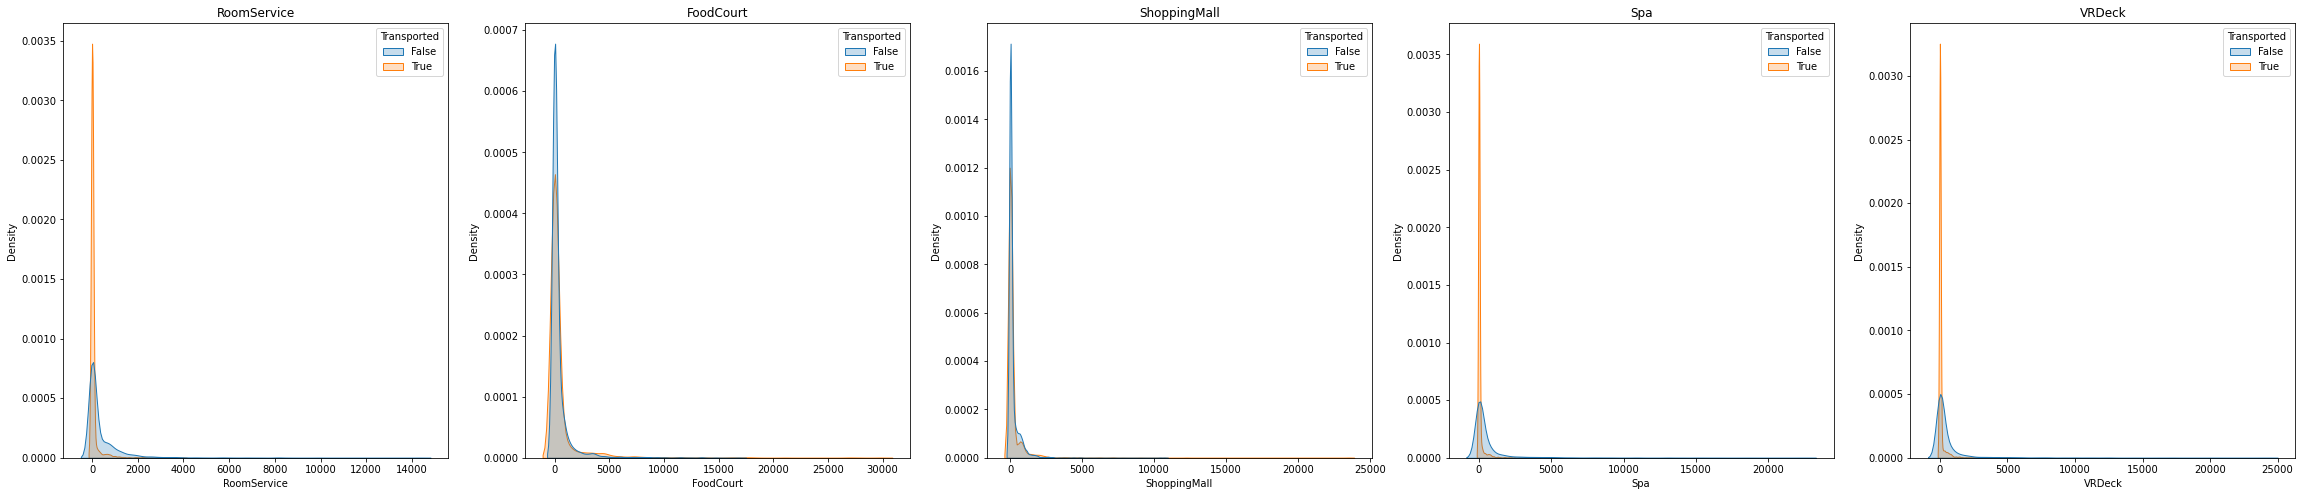

In [18]:
cols_to = ['RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck','Transported']
calc_df = train_set_eda[cols_to].copy()
fig, axes = plt.subplots(1, 5, figsize=(40,8))
for i, col in enumerate(cols_to[:-1]):
    sns.kdeplot(data=calc_df, x=col, hue='Transported', ax=axes[i], fill=True)
    axes[i].set_title(col)

These plots are difficult to interpret, so we will apply function **log1p** which is formulated as $ \ln{(1+x)} $ to the features and then plot the distributions.

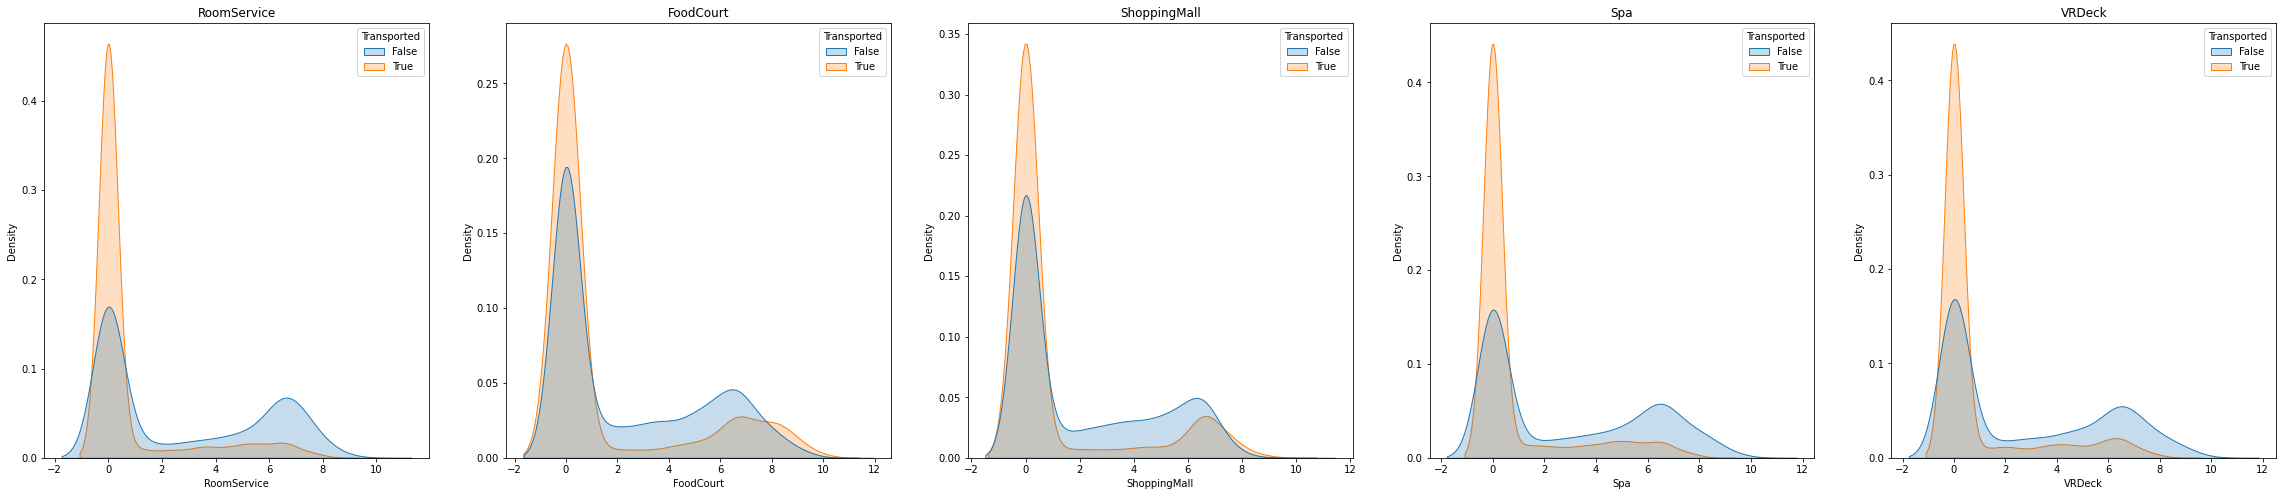

In [19]:
### investigate histograms of the outlier values
for col in cols_to[:-1]:
    calc_df[col] = calc_df[col].apply(np.log1p)
fig, axes = plt.subplots(1, 5, figsize=(40,8))
for i, col in enumerate(cols_to[:-1]):
    sns.kdeplot(data=calc_df, x=col, hue='Transported', ax=axes[i], fill=True)
    axes[i].set_title(col)

Now, we can see the distributions clearly. It is visible that for smaller spending values the passengers are more likely to be transported, while for larger spending values the passengers are less likely to be transported.

<AxesSubplot:>

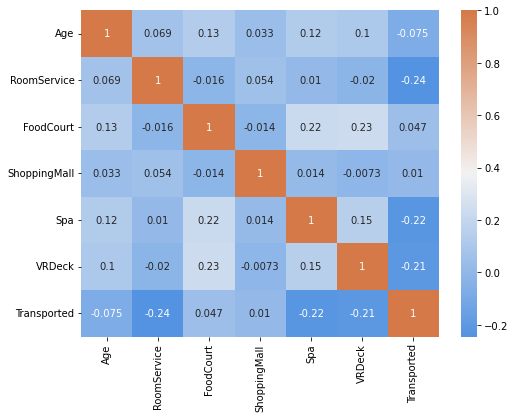

In [20]:
### get the correlation matrix of numerical columns
plt.figure(figsize=(8,6))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(250, 30, l=60, as_cmap=True))

#### 3. Building pipeline, feature selection and model selection.

In [22]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(train_set.drop('Transported', axis=1), train_set['Transported'], test_size=0.2, random_state=42)

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, **transform_params):
        df = X.copy()
        df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
        bins = [0, 15, 20, 30, 40, 50, 60, 100]
        group_names = ['0-15', '16-20', '21-30', '31-40', '41-50', '51-60', '61-100']
        df['AgeGroup'] = pd.cut(df['Age'], bins, labels=group_names)
        df[['RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck']].apply(np.log1p)
        df.drop(['PassengerId', 'Name', 'Cabin', 'Num'] , axis=1, inplace=True)   
        return df

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessing pipeline
column_tranformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck']),
        ('cat', categorical_transformer, ['Side', 'VIP', 'CryoSleep', 'HomePlanet', 'Destination', 'Deck', 'AgeGroup'])])

# accelerate xgboost by using GPU
ml_pipeline = Pipeline(steps=[('preprocessor', Preprocessor()),
    ('column_transformer', column_tranformer),
    ('classifier', XGBClassifier())])

# tune the parameters of the model
parameters = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.1, 0.05, 0.01],
    'classifier__objective': ['binary:logistic'],
    'classifier__tree_method': ['gpu_hist']
}

# perform grid search on the pipeline
grid_search = GridSearchCV(ml_pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[23:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


c:\Users\mwili\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mwili\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mwili\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\mwili\anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\mwili\anaconda3\lib\site-pac

XGBoostError: [23:05:09] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

In [ ]:
# print the best parameters and the best score
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

NameError: name 'grid_search' is not defined

In [ ]:
# save predictions
predictions = grid_search.predict(test_set)
pd.DataFrame({"PassengerId": test_set["PassengerId"], "Transported": predictions.astype(bool)}).to_csv('submission.csv', index=False)